# Make tensors (time, location, age; count)

In [2]:
import datetime
import os
import shutil
import warnings
import pandas as pd
import numpy as np
import tqdm

In [3]:
ROOTPATH = "../dat/raw/"
OUTPATH = "../dat/"
os.makedirs(OUTPATH, exist_ok=True)
warnings.filterwarnings("ignore")

In [4]:
def load_data(date_index):
    return pd.read_csv(ROOTPATH + date_index + "-citibike-tripdata.csv")

In [5]:
def generate_station_data(start="2017-01", end="2020-12", outpath=None):
    """ Extract the consisten station information
        between 'start' and 'end'.
    """

    df_station_list = []

    for date_index in tqdm.tqdm(pd.date_range(start="2016-01", end="2020-12", freq='m')):

        # original trip data
        df = load_data(date_index.strftime("%Y%m"))

        # ensure the consistency of column names
        df.columns = df.columns.str.replace(" ", "")
        df.columns = df.columns.str.lower()

        # start station data
        df_stt = df[[
            "startstationid",
            "startstationname",
            "startstationlatitude",
            "startstationlongitude"
        ]]

        # end station data
        df_end = df[[
            "endstationid",
            "endstationname",
            "endstationlatitude",
            "endstationlongitude"
        ]]

        # rename columns
        df_stt.columns = df_stt.columns.str.replace("start", "")
        df_end.columns = df_end.columns.str.replace("end", "")

        # get unique station data
        df = pd.concat([df_stt, df_end])
        df = df.drop_duplicates(subset=["stationid"])

        df_station_list.append(df.copy())

    # extract full station data
    station_data = pd.concat(df_station_list)
    station_data = station_data.drop_duplicates(subset=["stationid"])
    station_data = station_data.dropna(how="any")
    station_data = station_data.sort_values("stationname")
    station_data = station_data.reset_index(drop=True)  # remove unused index
    station_data = station_data.reset_index(drop=True)  # remove unused index
    station_data = station_data.reset_index()  # save unique id from zero
    station_data = station_data.astype({"stationid": int})

    if outpath is not None:
        station_data.to_csv(
            os.path.join(outpath, "station_data.csv"),
            index=False)

    return station_data

In [26]:
def process(df, year):
    """ Load $ preprocess the original trip data """
    # Cleaning
    df = df.dropna(how="any")
    df.columns = df.columns.str.replace(" ", "")
    df.columns = df.columns.str.lower()

    df = df.query("usertype=='Subscriber'")

    # Calculate user ages
    df["userage"] = year - df["birthyear"]

    # Extract columns that we want to use
    df = df[["starttime", "startstationid", "endstationid", "userage"]]
    df = df.reset_index(drop=True)

    # Cast
    return df.astype({
        "startstationid": int,
        "endstationid": int,
        "userage": int
    })

<AxesSubplot:>

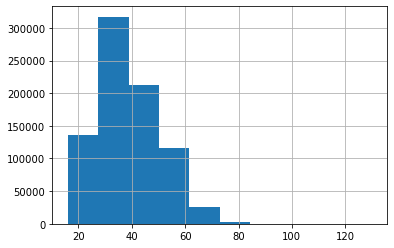

In [28]:
# sample
process(load_data("201506"), 2015).userage.hist()

In [29]:
def save_dataset(start="2017-01", end="2020-12"):

    dataset_path = OUTPATH + "citibike_{}_{}/".format(
        start.replace("-", ""), end.replace("-", ""))
    if os.path.exists(dataset_path):
        shutil.rmtree(dataset_path)
    os.makedirs(dataset_path)

    # Get Station Information
    station_data = generate_station_data(start, end, dataset_path)

    # Make Monthly Trip History
    for date_index in pd.date_range(start=start, end=end, freq='m'):

        # data loading and cleaning
        df = load_data(date_index.strftime("%Y%m"))
        df = process(df, date_index.year)

        # encode start station indices
        df = pd.merge(df, station_data[["index", "stationid"]],
                      how="left",
                      left_on="startstationid",
                      right_on="stationid")

        df = df.rename({"index": "start_station_dim"}, axis=1)
        del df["stationid"]

        # encode end station indices
        df = pd.merge(df, station_data[["index", "stationid"]],
                      how="left",
                      left_on="endstationid",
                      right_on="stationid")

        df = df.rename({"index": "end_station_dim"}, axis=1)
        del df["stationid"]

        # final cleaning
        df = df.dropna(how="any")

        # save
        filename = "tripdata_{}.csv".format(date_index.strftime("%Y%m"))
        print("[SAVED]", filename)
        df.to_csv(dataset_path + filename, index=False)

In [30]:
save_dataset(start="2017-03", end="2021-04")
# save_dataset(start="2019-03", end="2021-04")  # 2021-04 will be excluded
# save_dataset(start="2017-01", end="2021-01")

100%|██████████| 59/59 [02:38<00:00,  2.68s/it]
2017
[SAVED] tripdata_201703.csv
2017
[SAVED] tripdata_201704.csv
2017
[SAVED] tripdata_201705.csv
2017
[SAVED] tripdata_201706.csv
2017
[SAVED] tripdata_201707.csv
2017
[SAVED] tripdata_201708.csv
2017
[SAVED] tripdata_201709.csv
2017
[SAVED] tripdata_201710.csv
2017
[SAVED] tripdata_201711.csv
2017
[SAVED] tripdata_201712.csv
2018
[SAVED] tripdata_201801.csv
2018
[SAVED] tripdata_201802.csv
2018
[SAVED] tripdata_201803.csv
2018
[SAVED] tripdata_201804.csv
2018
[SAVED] tripdata_201805.csv
2018
[SAVED] tripdata_201806.csv
2018
[SAVED] tripdata_201807.csv
2018
[SAVED] tripdata_201808.csv
2018
[SAVED] tripdata_201809.csv
2018
[SAVED] tripdata_201810.csv
2018
[SAVED] tripdata_201811.csv
2018
[SAVED] tripdata_201812.csv
2019
[SAVED] tripdata_201901.csv
2019
[SAVED] tripdata_201902.csv
2019
[SAVED] tripdata_201903.csv
2019
[SAVED] tripdata_201904.csv
2019
[SAVED] tripdata_201905.csv
2019
[SAVED] tripdata_201906.csv
2019
[SAVED] tripdata_201907